In [58]:
import pandas as pd
df = pd.read_csv('dataset/Train.csv')
df.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376


In [59]:
col = ['Inv_Id','Product_Category', 'Item_Description']
df = df[col]

In [60]:
df['category_id'] = df['Product_Category'].factorize()[0]
from io import StringIO
category_id_df = df[['Product_Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product_Category']].values)

In [61]:
df.head()


,Inv_Id,Product_Category,Item_Description,category_id
0,15001,CLASS-1963,Artworking/Typesetting Production Jun 2009 Cha...,0
1,15002,CLASS-1250,Auto Leasing Corporate Services Corning Inc /N...,1
2,15004,CLASS-1274,Store Management Lease/Rent Deltona Corp Real ...,2
3,15005,CLASS-1522,Store Construction General Requirements Coloni...,3
4,15006,CLASS-1376,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,4


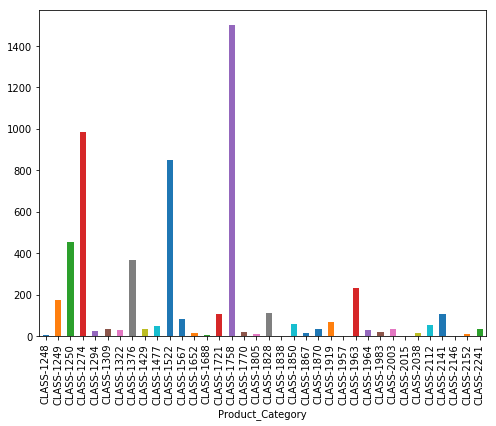

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product_Category').Item_Description.count().plot.bar(ylim=0)
plt.show()

In [63]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Item_Description).toarray()
labels = df.category_id
features.shape

(5566, 2113)

In [64]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product_Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product_Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'CLASS-1248':
  . Most correlated unigrams:
       . risk
       . consulting
  . Most correlated bigrams:
       . finance consulting
       . audit risk
# 'CLASS-1249':
  . Most correlated unigrams:
       . fleet
       . repair
  . Most correlated bigrams:
       . repair maintenance
       . fleet repair
# 'CLASS-1250':
  . Most correlated unigrams:
       . auto
       . leasing
  . Most correlated bigrams:
       . corning ny
       . auto leasing
# 'CLASS-1274':
  . Most correlated unigrams:
       . base
       . rent
  . Most correlated bigrams:
       . base rent
       . lease rent
# 'CLASS-1294':
  . Most correlated unigrams:
       . property
       . building
  . Most correlated bigrams:
       . building property
       . property insurance
# 'CLASS-1309':
  . Most correlated unigrams:
       . brokerage
       . catalogue
  . Most correlated bigrams:
       . cv brokerage
       . traditional catalogue
# 'CLASS-1322':
  . Most correlated unigrams:
       . organizati

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Item_Description'], df['Product_Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [69]:
#Predict class  based on item_description using MultinomialNB

print(clf.predict(count_vect.transform(["Agway Inc Auto Fleet Repair and Maintenance Aug-2011 Auto Leasing and Maintenance Other Corporate Services Corporate Services"])))

['CLASS-1250']


In [70]:
#check Actual class as per data

df[df['Item_Description'] == "Agway Inc Auto Fleet Repair and Maintenance Aug-2011 Auto Leasing and Maintenance Other Corporate Services Corporate Services"]

,Inv_Id,Product_Category,Item_Description,category_id
1700,17472,CLASS-1249,Agway Inc Auto Fleet Repair and Maintenance Au...,9


In [ ]:
#since class doesn't matches try different algorithms and check accuracy

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of 

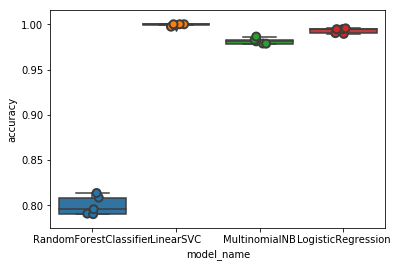

In [72]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [73]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.999290
LogisticRegression        0.992835
MultinomialNB             0.981518
RandomForestClassifier    0.799725
Name: accuracy, dtype: float64

In [74]:
#As LinerSVC has higher accuracy,predict the same item_description used above and check class
from sklearn.svm import LinearSVC

clf1 = LinearSVC().fit(X_train_tfidf, y_train)

In [75]:
print(clf1.predict(count_vect.transform(["Agway Inc Auto Fleet Repair and Maintenance Aug-2011 Auto Leasing and Maintenance Other Corporate Services Corporate Services	"])))

['CLASS-1249']


In [77]:
#check Actual class as per data
df[df['Item_Description'] == "Agway Inc Auto Fleet Repair and Maintenance Aug-2011 Auto Leasing and Maintenance Other Corporate Services Corporate Services"]

,Inv_Id,Product_Category,Item_Description,category_id
1700,17472,CLASS-1249,Agway Inc Auto Fleet Repair and Maintenance Au...,9


In [ ]:
#AS the class above matches we will use LinearSVC for training and prediction

In [28]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [32]:

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X_train_all=df['Item_Description']
y_train_all=df['Product_Category']

X_train_all_counts = count_vect.fit_transform(X_train_all)
tfidf_transformer_all = TfidfTransformer()
X_train_tfidf_all = tfidf_transformer_all.fit_transform(X_train_all_counts)

clf2 = LinearSVC().fit(X_train_tfidf_all, y_train_all)

In [35]:
df1=pd.read_csv('dataset/test.csv')

In [39]:
df2=df1[['Inv_Id','Item_Description']]

In [43]:
predicted_result=clf2.predict(count_vect.transform(df2.Item_Description))

In [47]:
len(predicted_result)

2292

In [54]:
output=pd.DataFrame({'Inv_Id':df2.Inv_Id,'Product_Category':predicted_result})

In [56]:
output.to_csv('dataset/submission.csv', index=False)